In [1]:
import pandas as pd
# import os
from datetime import datetime, timedelta
import re

import numpy as np

from pandas.tseries.offsets import BDay

import os, sys
module_path = os.path.abspath(os.path.join('./download-tick-from-dukascopy'))
if module_path not in sys.path:
    sys.path.append(module_path)
import download_tick_from_dukascopy

path = 'data'
inst_txt_path = 'insts.txt'

DATE_RANGE = 5

In [2]:
# inst = 'BTCUSD'
# inst = 'USA500IDXUSD'
# inst = 'USATECHIDXUSD'

# if inst not in os.listdir(path):
#     os.mkdir('{}/{}'.format(path, inst))
    
#
#   To do:
#       - Check if already in data
#       - Download days you don't have
#
    
# gotta loop through this, and handle no columns (1kb .csv)

# check handling quitting


In [3]:
def get_all(inst):
    # concat all .csvs within dir
    data = pd.DataFrame()
    
    files = [
        file for file 
        in os.listdir('{}/{}'.format(path, inst)) 
        if os.path.getsize('{}/{}/{}'.format(path, inst, file)) > 2
    ]
    
    for csv in files:
        data = pd.concat([
            data,
            pd.read_csv(
                '{}/{}/{}'.format(path, inst, csv),
                header=None
            )
        ])
    data.columns = ['dt', 'bid', 'ask', 'bidvol', 'askvol']
    return data


def clean(inst):
    data = get_all(inst)
    # dd = len(data)
    data = data.drop_duplicates()
    # print('{} duplicate rows dropped'.format(dd-len(data)))
    # data = data.sort_values('dt')
    # print('max: {}'.format(data['dt'].max()))
    data['mid'] = (data['bid'] + data['ask']) / 2
    data.index = data['dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
    data = data[['mid']].resample('1Min').ohlc()
    return data

In [4]:
# # inst = 'USATECHIDXUSD'
# # inst = 'BTCUSD'
# inst = 'USA500IDXUSD'

# data = clean(inst)
# data

In [5]:
# # take last datetime, find difference from current date
# # datetime.strptime(data.index.max(), '%Y-%m-%d %H:%M:%S.%f')
# (datetime.now() - data.index.max()).days

In [6]:
# # just get last week because it's less annoying
# datetime.strftime((datetime.now() - timedelta(7)), '%Y-%m-%d')

In [7]:
# class insts list

# class inst
    # start date
    # end date
    # write to csv
    # do things

In [8]:
# with open(inst_txt_path, 'r') as f:
#     insts = f.read().split('\n')
# print(insts)

# for inst in insts:
#     print(inst)
#     if inst not in os.listdir(path):
#         os.mkdir('{}/{}'.format(path, inst))
#     print(os.listdir('{}/{}'.format(path, inst)))
    
#     # consider making some meta-file that keeps last updated date instead of concatting everytime
    

In [9]:
def check_max(inst):
    
    # Returns min/max date from current data by:
    # 1.) Finding max filename (doesn't account for end date of data .csv)
    # 2.) Finding max date within that file (doesn't account for gaps)
    
    files = [
        file for file 
        in os.listdir('{}/{}'.format(path, inst)) 
        if os.path.getsize('{}/{}/{}'.format(path, inst, file)) > 2
    ]
    
    if files:
    
        # Check
        csv = max(files)
        inst_max = re.search('[0-9]{4}-[0-9]{2}-[0-9]{2}', max(files)).group(0)

        #     data = pd.read_csv('{}/{}/{}'.format(path, inst, csv), header=None)
        #     data.columns = ['dt', 'bid', 'ask', 'bidvol', 'askvol']
        #     # data = data.drop_duplicates()
        #     data.index = data['dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
        #     # data = data[['bid']].resample('1Min').first()
        #     inst_max = data.index.max().date()

        # Get min date data
        csv = min(files)
        inst_min = re.search('[0-9]{4}-[0-9]{2}-[0-9]{2}', min(files)).group(0)

        #     data = pd.read_csv('{}/{}/{}'.format(path, inst, csv), header=None)
        #     data.columns = ['dt', 'bid', 'ask', 'bidvol', 'askvol']
        #     data.index = data['dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
        #     inst_max = data.index.max().date()
        
    else:
        
        # inst_max = datetime.strftime(datetime.today(), '%Y-%m-%d')
        # inst_min = datetime.strftime((datetime.today() - BDay(DATE_RANGE)).date(), '%Y-%m-%d')
        inst_min = False
        inst_max = False
    
    return inst_min, inst_max


def download(inst, start_date, end_date):
    
    # given start and end date, download each inst a day at a time
    
    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    diff = (end_dt - start_dt).days
    date_list = [datetime.strftime(end_dt - timedelta(days=x), '%Y-%m-%d') for x in range(0, diff)]
    
    for date in date_list:
        download_tick_from_dukascopy.main(inst, date, date, './{}/{}'.format(path, inst))

        
def check_current(inst):
    
    # check current date against last updated date for all inst's
    
    inst_min, inst_max = check_max(inst)

    if all([inst_min, inst_max]):
    
        # Checking start date
        # If min < than this, you're good.
        if datetime.strptime(inst_min, '%Y-%m-%d').date() < (datetime.today() - BDay(DATE_RANGE)).date():
            print('start date good')

        # Else, download from this to whereever the min was.  
        else:
            to_download_start = datetime.strftime((datetime.today() - BDay(DATE_RANGE)).date(), '%Y-%m-%d')
            to_download_end = inst_min

            download(inst, to_download_start, to_download_end)

        # Checking end date
        if datetime.strptime(inst_max, '%Y-%m-%d').date() == datetime.today().date():
            print('end date good')

        # else, download from max to today
        else:
            to_download_start = inst_max
            to_download_end = datetime.strftime(datetime.today(), '%Y-%m-%d')

            download(inst, to_download_start, to_download_end)
            
    else:
        to_download_start = datetime.strftime((datetime.today() - BDay(DATE_RANGE)).date(), '%Y-%m-%d')
        to_download_end = datetime.strftime(datetime.today(), '%Y-%m-%d')

        download(inst, to_download_start, to_download_end)

    return



def handle_check(inst):
    
    tries = 0
    
    try:
        check_current(inst)
    except OSError as e: # may be redundant if handling in update()
        print(e)
        
        if inst not in os.listdir(path):
            os.mkdir('{}/{}'.format(path, inst))
        
        handle_check(inst)
    except urllib2.URLError as e: # not sure if this wil work, will have to check later... could make inf loop
        print('URLError', e)
        tries += handle_check(inst)
        print('e tries', tries)
        
    print('all tries', tries)
    return tries

In [10]:
def update():
    
    # update all things
        
    with open(inst_txt_path, 'r') as f:
        insts = f.read().split('\n')
    print(insts)

    for inst in insts:
        print(inst)
        if inst not in os.listdir(path):
            os.mkdir('{}/{}'.format(path, inst))
        # print(os.listdir('{}/{}'.format(path, inst)))
        
        handle_check(inst)
    
    # consider making some meta-file that keeps last updated date instead of concatting everytime
    
    
    
    return

In [11]:
# inst = 'USATECHIDXUSD'

In [ ]:
update()

In [12]:
# with open(inst_txt_path, 'r') as f:
#     insts = f.read().split('\n')
# print(insts)

# for inst in insts:
#     print(inst)
#     if inst not in os.listdir(path):
#         os.mkdir('{}/{}'.format(path, inst))
#     print(os.listdir('{}/{}'.format(path, inst)))
    
#     # consider making some meta-file that keeps last updated date instead of concatting everytime
    

In [16]:
%%time
# Try getting avg rotations
inst = 'GBPUSD'
data = clean(inst)

Wall time: 5.22 s


In [25]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# data['mid']['close'].plot()

In [19]:
data = data['mid']

In [20]:
# Get sign of each bar (-1, 0, 1)
data['sign'] = np.sign(data['close'] - data['open'])

# Group together (including 0's at end of group)
prev = data['sign'][0]
g = 0
for i, s in tqdm(zip(data.index, data['sign'])):
    if s == 1:
        if prev == 1:
            # continue up group
            # print(i, s, 'yes', g)
            data.loc[i, 'g'] = g
        else:
            # new up group
            # iterate group
            g += 1
            # print(i, s, 'new', g)
            data.loc[i, 'g'] = g
    if s == -1:
        if prev == -1:
            # continue down group
            # print(i, s, 'yes', g)
            data.loc[i, 'g'] = g
        else:
            # new down group
            # iterate group
            g += 1
            # print(i, s, 'new', g)
            data.loc[i, 'g'] = g
    if s == 0:
        # add to last group
        # print(i, s, 'add to last', g)
        data.loc[i, 'g'] = g
    prev = s
    
# Now I'm thinking of grouping them two legs (of single "rotation") together
# If it's down/up, find the low.
# If it's up/down, find the high.
# This gets us the most accurate points for each rotation.


r = []
for x in tqdm(range(int(max(data['g'])))):
    # if g == x or x+1, find min/max
    # if g sign is +, find the +/- rot (high)
    # if g sign is -, find -/+ rot (low)
    
    if data.loc[data['g'] == x, 'sign'].iloc[0] > 0:
        h = data.loc[(data['g'] == x) | (data['g'] == x+1), 'high']
        i = h.idxmax()
        h = h.max()
        # data.loc[i, 'r'] = h
        r.append([i, h])
    if data.loc[data['g'] == x, 'sign'].iloc[0] < 0:
        l = data.loc[(data['g'] == x) | (data['g'] == x+1), 'low']
        i = l.idxmin()
        l = l.min()
        # data.loc[i, 'r'] = l
        r.append([i, l])

In [21]:
data

,open,high,low,close,sign,g
dt,,,,,,
2021-04-06 00:00:00,1.391240,1.391240,1.391050,1.391225,-1.0,0.0
2021-04-06 00:01:00,1.391200,1.391395,1.391170,1.391335,1.0,1.0
2021-04-06 00:02:00,1.391360,1.391405,1.391320,1.391380,1.0,1.0
2021-04-06 00:03:00,1.391375,1.391380,1.391155,1.391160,-1.0,2.0
2021-04-06 00:04:00,1.391155,1.391160,1.391065,1.391070,-1.0,2.0
...,...,...,...,...,...,...
2021-04-12 05:55:00,1.369165,1.369170,1.369075,1.369075,-1.0,3045.0
2021-04-12 05:56:00,1.369080,1.369225,1.369075,1.369225,1.0,3046.0
2021-04-12 05:57:00,1.369275,1.369435,1.369275,1.369425,1.0,3046.0


TypeError: 'int' object is not subscriptable

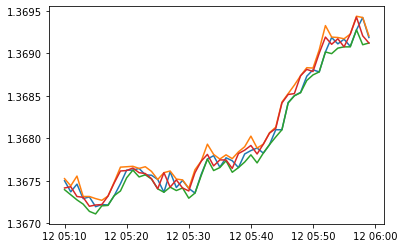

In [28]:
plt.plot(data[['open', 'high', 'low', 'close']][-50:])
plt.scatter([x[0] for x in r[-27:]], [x[1] for x in r[-27:]])

In [31]:
# Now I'm thinking of grouping them two legs (of single "rotation") together
# If it's down/up, find the low.
# If it's up/down, find the high.
# This gets us the most accurate points for each rotation.

r = []
for x in tqdm(range(int(max(data['g'])))):
    # if g == x or x+1, find min/max
    # if g sign is +, find the +/- rot (high)
    # if g sign is -, find -/+ rot (low)
    
    if data.loc[data['g'] == x, 'sign'].iloc[0] > 0:
        h = data.loc[(data['g'] == x) | (data['g'] == x+1), 'high']
        i = h.idxmax()
        h = h.max()
        # data.loc[i, 'r'] = h
        r.append([i, h])
    if data.loc[data['g'] == x, 'sign'].iloc[0] < 0:
        l = data.loc[(data['g'] == x) | (data['g'] == x+1), 'low']
        i = l.idxmin()
        l = l.min()
        # data.loc[i, 'r'] = l
        r.append([i, l])

In [32]:
r = pd.DataFrame(r)
r['d'] = r[1].diff()
r['ad'] = abs(r['d'])

In [39]:
# dependent on scaling
r[['d', 'ad']] = r[['d', 'ad']] * 10000

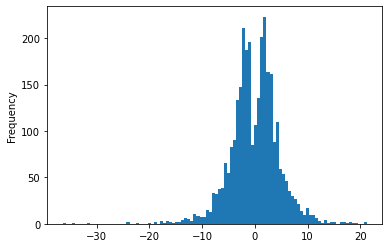

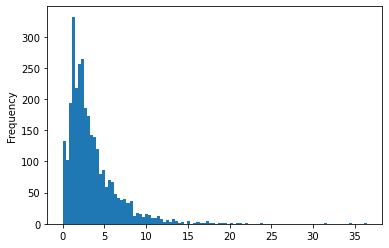

In [41]:
r['d'].plot(kind='hist', bins=100)
plt.show()
r['ad'].plot(kind='hist', bins=100)
plt.show()

In [42]:
r['ad'].describe()

count    3046.000000
mean        3.491284
std         3.101680
min         0.000000
25%         1.500000
50%         2.650000
75%         4.487500
max        36.450000
Name: ad, dtype: float64

In [40]:
r

,0,1,d,ad
0,2021-04-06 00:00:00,1.391050,NaN,NaN
1,2021-04-06 00:02:00,1.391405,3.55,3.55
2,2021-04-06 00:04:00,1.391065,-3.40,3.40
3,2021-04-06 00:08:00,1.391475,4.10,4.10
4,2021-04-06 00:13:00,1.390840,-6.35,6.35
...,...,...,...,...
3042,2021-04-12 05:52:00,1.369325,5.80,5.80
3043,2021-04-12 05:53:00,1.368995,-3.30,3.30
3044,2021-04-12 05:54:00,1.369185,1.90,1.90
3045,2021-04-12 05:55:00,1.369075,-1.10,1.10


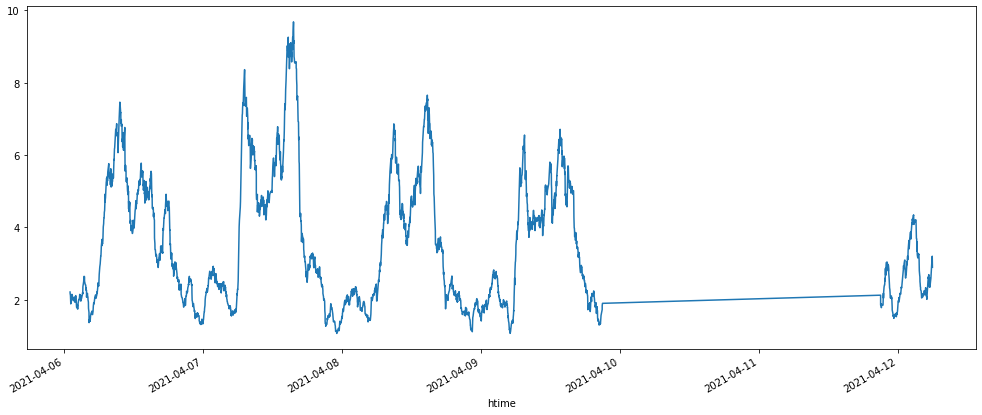

In [56]:
r['adr'] = r['ad'].rolling(30).mean()
r['htime'] = r[0]
# r.set_index('htime')['adr'].dropna().plot(figsize=(13, 5))

r.set_index('htime')['adr'].plot(
    figsize=(17,7)
)

In [45]:
r.quantile(.90)

1      1.385379
d      5.050000
ad     7.150000
dr     0.396667
adr    6.048000
Name: 0.9, dtype: float64

In [46]:
r.quantile(.95)

1      1.389654
d      7.050000
ad     9.150000
dr     0.541667
adr    6.681667
Name: 0.95, dtype: float64